In [1]:
import numpy as np
import math
import itertools
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import qiskit
import qiskit.quantum_info as qi 
# import warnings
# warnings.filterwarnings('ignore')
import time
import networkx as nx


In [2]:
# produce all binary strings of length n with k 1s. If k is None then all possible binary strings of length n produced
def get_binary_strings(n, k=None) -> list[list]:
    '''
    produce all binary strings of length n with k 1s
    returns list with binary lists 
    '''
    final = []
    def kbits(r):
        result = []
        for bits in itertools.combinations(range(n), r):
            s = [0] * n
            for bit in bits:
                s[bit] = 1
            result.append(s)   
        return result

    if k != None:
        return kbits(k)
    
    for i in range(n + 1):
        final = final + kbits(i)
        
    return final


In [3]:
# lst is a list of pairs where pauli matrix is paired with ith qubit
def get_circuit_operators( lst_x=None, lst_z=None):
    '''
    note the order! (x,z)
    '''
    # returns for example X @ I @ I @ X @ I where @ is tensor product
    return  qi.SparsePauliOp(qi.Pauli((lst_z,lst_x)))

In [4]:
def generate_QAOA_operator(nqubits, locality, number_of_terms):
    ''' 
    nqubits
    locality
    number_of_terms
    '''
    beta_angle = np.pi/12
    cos_angle_beta = np.cos(beta_angle)
    sin_angle_beta = np.sin(beta_angle)

    gamma_angle = np.pi/12
    cos_angle_gamma = np.cos(gamma_angle)
    sin_angle_gamma = np.sin(gamma_angle)
 
    locality = min(locality, nqubits)
    number_of_terms = min(number_of_terms,nqubits)

    # Hamiltonian  ZjZk
    rng = np.random.default_rng()
    Zs = get_binary_strings(nqubits,locality)
    # pickedZ = np.random.choice(Zs,size=number_of_terms,replace=False)
    pickedZ = rng.choice(Zs, number_of_terms, replace=False)


    # Making Hamiltonian and unitary for Hamiltonian exp
    identity = get_circuit_operators(np.zeros(nqubits),np.zeros(nqubits))

    H = 0
    unitary_z = identity
    # print(pickedZ)


    for i in range(0,len(pickedZ)):
        H = H + get_circuit_operators(np.zeros(nqubits),pickedZ[i])
        unitary_z = unitary_z@(cos_angle_beta*identity \
        - 1j*sin_angle_beta*get_circuit_operators(np.zeros(nqubits),pickedZ[i]))
    # print(H)
    # print(unitary_z)

    # Making mixer X
    x_string = np.zeros(nqubits)
    x_string[0] = 1
    unitary_x = identity


    x_string[0] = 0
    for i in range(0,nqubits):
        x_string[i] = 1
        unitary_x = unitary_x@(cos_angle_gamma*identity \
        - 1j*sin_angle_gamma*get_circuit_operators(x_string,np.zeros(nqubits)))
        x_string[i] = 0
    # print(unitary_x)
    unitary_x = unitary_x.simplify()
    unitary_z = unitary_z.simplify()
    ans = unitary_z @ unitary_x @ H.simplify() @ unitary_x.adjoint() @ unitary_z.adjoint()
    # print(unitary_z.simplify(),";;\n", unitary_x.simplify(),';;\n',H.simplify())
    return ans
   
    


In [5]:
def helper_pauli_counter(P_str):
    counter = 0
    for i in P_str:
        if i == 'Z' or i == 'Y':
            return -1
        if i == 'X':
            counter+=1
    return counter

In [6]:
def count_solutions_XI(Pauli_strings: qi.SparsePauliOp, tol: float, if_print = False ) -> tuple:
    choped = Pauli_strings.simplify(atol=tol).to_list()
    ans = []
    max_locality  = 0
    avg_locality = 0.0
    for i in choped:
        count_x = helper_pauli_counter(i[0])
        if  count_x != -1:
            ans.append(i)
            if count_x > max_locality:
                max_locality = count_x
            avg_locality += count_x
    len_ans = len(ans)
    if if_print:
        print("Non-zero Pauli strings:", len_ans)
        print("Max locality:", max_locality)
        print("Avg locality:", avg_locality/len_ans)
    return ans, max_locality, avg_locality/len_ans, len_ans


In [7]:
ans = generate_QAOA_operator(5,5,1)
# ans,loc,avg, len_ans = count_solutions_XI(ans,1e-10)
print(ans.to_list())

[('ZZZZZ', (0.6596678783944643+0j)), ('IIIII', 0.17675747528854874j), ('YZZZZ', (-0.17675747528854874+0j)), ('XIIII', (0.04736202275973076-0j)), ('ZYZZZ', (-0.17675747528854874+0j)), ('IXIII', (0.04736202275973076-0j)), ('YYZZZ', (0.047362022759730754+0j)), ('XXIII', (-0-0.012690615750374308j)), ('ZZYZZ', (-0.17675747528854874+0j)), ('IIXII', (0.04736202275973076-0j)), ('YZYZZ', (0.047362022759730754+0j)), ('XIXII', (-0-0.012690615750374308j)), ('ZYYZZ', (0.047362022759730754+0j)), ('IXXII', (-0-0.012690615750374308j)), ('YYYZZ', (-0.012690615750374307+0j)), ('XXXII', (-0.003400440241766481-0j)), ('ZZZYZ', (-0.17675747528854874+0j)), ('IIIXI', (0.047362022759730754-0j)), ('YZZYZ', (0.047362022759730754+0j)), ('XIIXI', (-0-0.012690615750374308j)), ('ZYZYZ', (0.04736202275973075+0j)), ('IXIXI', (-0-0.012690615750374307j)), ('YYZYZ', (-0.012690615750374307+0j)), ('XXIXI', (-0.003400440241766481-0j)), ('ZZYYZ', (0.04736202275973075+0j)), ('IIXXI', (-0-0.012690615750374307j)), ('YZYYZ', (-0

In [8]:
ans, max_loc, avg_loc, len_ans = count_solutions_XI(ans,1e-10)

In [9]:
ans

[('XIIII', (0.14062500000000006+0j)),
 ('IXIII', (0.14062500000000003+0j)),
 ('IIXII', (0.14062500000000003+0j)),
 ('XXXII', (-0.046875+0j)),
 ('IIIXI', (0.140625+0j)),
 ('XXIXI', (-0.046875+0j)),
 ('XIXXI', (-0.046875+0j)),
 ('IXXXI', (-0.04687499999999999+0j)),
 ('IIIIX', (0.14062500000000003+0j)),
 ('XXIIX', (-0.046875+0j)),
 ('XIXIX', (-0.046875+0j)),
 ('IXXIX', (-0.046875+0j)),
 ('XIIXX', (-0.04687499999999999+0j)),
 ('IXIXX', (-0.046874999999999986+0j)),
 ('IIXXX', (-0.046875+0j)),
 ('XXXXX', (0.015624999999999998+0j))]

In [17]:
def make_grid(nqubits: int, max_loc: int, max_terms: int, save=False)->np.ndarray:
    grid = np.zeros((max_loc,max_terms,3))
    if save:
        with open('localityPaulis{}.npy'.format(nqubits), 'wb') as f:
            for i in range(1,max_loc+1):
                for j in range(1,max_terms+1):
                    if i==nqubits and j>1:
                        # grid[i-1][j-1][2] = grid[i-1][0][2]
                        continue
                    ans = generate_QAOA_operator(nqubits=nqubits,locality=i,number_of_terms=j)
                    ans, max_loc, avg_loc, len_ans = count_solutions_XI(ans,1e-10)
                    np.save(f, 'loc {}, term {}'.format(i,j))
                    np.save(f, ans)
                    grid[i-1][j-1][0] = max_loc
                    grid[i-1][j-1][1] = avg_loc
                    grid[i-1][j-1][2] = len_ans            
    else:
        for i in range(1,max_loc+1):
            for j in range(1,max_terms+1):
                if i==nqubits and j>1:
                    # grid[i-1][j-1][2] = grid[i-1][0][2]
                    continue
                ans = generate_QAOA_operator(nqubits=nqubits,locality=i,number_of_terms=j)
                ans, max_loc, avg_loc, len_ans = count_solutions_XI(ans,1e-10)
                grid[i-1][j-1][0] = max_loc
                grid[i-1][j-1][1] = avg_loc
                grid[i-1][j-1][2] = len_ans   
    return grid


In [18]:
def plot_grid(grid: np.ndarray, param_to_show=2):

    localities = [i + 1 for i in range(grid.shape[0])]
    num_of_terms = [i + 1 for i in range(grid.shape[1])]

    param_to_show_name = ''
    if param_to_show == 2:
        param_to_show_name = 'total terms'
    elif param_to_show == 1:
        param_to_show_name = 'average locality'
    else:
        param_to_show_name = 'max locality'


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(grid[:,:,param_to_show], interpolation='nearest', cmap='plasma')
    
    # ax.set_yticks(localities)
    # ax.set_xticks(num_of_terms)

    fig.colorbar(cax)
    
    for locality in localities:
        for number_of_terms in num_of_terms:
            # print(locality,number_of_terms)
            ax.text(number_of_terms-1, locality-1, '{:.2f}'.format(grid[locality-1][number_of_terms-1][param_to_show]),  ha='center', va='center')
            
    ax.set_xlabel('No. of Terms', fontsize = 15)
    ax.set_ylabel('Locality', fontsize = 15)
    ax.set_title('Qubits {}, {}'.format(len(localities), param_to_show_name), fontsize = 20)

    plt.show()

In [19]:
grid = make_grid(6, 6, 6)

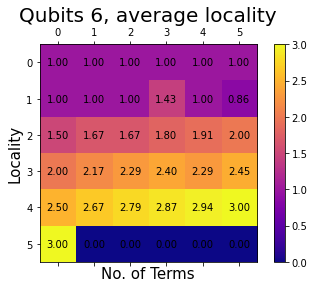

In [20]:
plot_grid(grid,1)

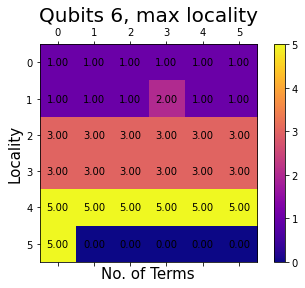

In [21]:
plot_grid(grid,0)

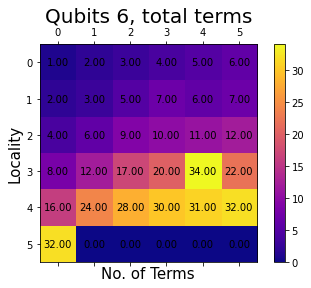

In [22]:
plot_grid(grid,2)

In [13]:
import cProfile
cProfile.run('make_grid(5, 5, 5)')

         54531338 function calls (54527914 primitive calls) in 12.592 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       21    0.000    0.000    0.000    0.000 1978470549.py:2(get_binary_strings)
       21    0.000    0.000    0.000    0.000 1978470549.py:8(kbits)
       21    0.042    0.002    2.524    0.120 2709223764.py:1(count_solutions_XI)
     1324    0.000    0.000    0.000    0.000 321733110.py:1(helper_pauli_counter)
      248    0.001    0.000    0.016    0.000 3513871143.py:2(get_circuit_operators)
       21    0.006    0.000   10.020    0.477 3812479280.py:1(generate_QAOA_operator)
        1    0.042    0.042   12.592   12.592 3883759235.py:1(make_grid)
        1    0.000    0.000   12.592   12.592 <string>:1(<module>)
     1101    0.001    0.000    0.659    0.001 _methods.py:47(_sum)
       42    0.000    0.000    0.000    0.000 _methods.py:55(_any)
       42    0.000    0.000    0.000    0.000 _methods.py:

In [14]:
%load_ext line_profiler

In [16]:
%lprun -f make_grid make_grid(5,5,5)

Timer unit: 1e-07 s

Total time: 19.5506 s
File: C:\Users\dimav\AppData\Local\Temp\ipykernel_15968\3883759235.py
Function: make_grid at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def make_grid(nqubits: int, max_loc: int, max_terms: int)->np.ndarray:
     2         1        128.0    128.0      0.0      grid = np.zeros((max_loc,max_terms,3))
     3         1       3689.0   3689.0      0.0      with open('localityPaulis{}.npy'.format(nqubits), 'wb') as f:
     4         5         42.0      8.4      0.0          for i in range(1,max_loc+1):
     5        25        180.0      7.2      0.0              for j in range(1,max_terms+1):
     6        21         66.0      3.1      0.0                  if i==nqubits and j>1:
     7                                                               # grid[i-1][j-1][2] = grid[i-1][0][2]
     8         4         10.0      2.5      0.0                      continue
     9        2

In [18]:
%lprun -f generate_QAOA_operator generate_QAOA_operator(5,3,3)

Timer unit: 1e-07 s

Total time: 0.210317 s
File: C:\Users\dimav\AppData\Local\Temp\ipykernel_15968\3812479280.py
Function: generate_QAOA_operator at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def generate_QAOA_operator(nqubits, locality, number_of_terms):
     2                                               ''' 
     3                                               nqubits
     4                                               locality
     5                                               number_of_terms
     6                                               '''
     7         1         36.0     36.0      0.0      beta_angle = np.pi/12
     8         1        370.0    370.0      0.0      cos_angle_beta = np.cos(beta_angle)
     9         1         53.0     53.0      0.0      sin_angle_beta = np.sin(beta_angle)
    10                                           
    11         1          6.0      6.0      0.0      gam